# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.


### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Understanding The Data

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
from datetime import datetime

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [89]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [90]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [91]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [92]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [93]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [94]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [95]:
def clean_profile_dataset(df):
    """
    performs the following:
        1- copy the data frame to wrangle the data
        2- convert 'became_member_on' column type to date
        3- create dataframe binary columns from each gender in 'gender' column then merge them with cleaned origianl data
        4- set missing date in 'age' column to nan instead of 118
        5- categorize customers in to their proper age category
        6- create dataframe binary columns from each age category in 'age_category' column then merge them with cleaned origianl data
        7- drop duplicated row if they exist
        8- rename 'id' column to 'user_id'
    
    args:
        df (Dataframe): the profile dataset dataframe
    
    return:
        df (Dataframe): the cleaned profile dataset dataframe
    """
    
    # copy the dataframe before wrangling the data 
    df = df.copy()
    
    # drop duplicates
    print("number of duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("number of duplicates after the drop: ", df.duplicated().sum())
        
    # convert 'became_member_on' column type to date
    df['became_member_on'] = df['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d') )
    
    # create dataframe binary columns from each gender in 'gender' column 
    df_gender = pd.get_dummies(df['gender'],prefix="gender_")
    
    # merge dataframe binary columns from each gender in 'gender' column with cleaned origianl dataframe 
    df = pd.concat([df, df_gender], axis=1)
    
    # set missing date in 'age' column to nan instead of 118
    df['age'] = df['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # categorize customers in to their proper age category based categories on found in study in https://pubmed.ncbi.nlm.nih.gov/11815703/#:~:text=Participants%20were%20categorized%20by%20age,were%20compared%20across%20the%20groups.
    df['age_category']  = pd.cut(df['age'], bins=[18,35,55,118], labels=['young-adult','adult','elderly'], right=False)
    
    # create dataframe binary columns from each gender in 'gender' column 
    df_age_category = pd.get_dummies(df['age_category'])
    
    # merge dataframe binary columns from each gender in 'gender' column with cleaned origianl dataframe 
    df = pd.concat([df, df_age_category], axis=1)
    
    # rename 'id' column to 'user_id'
    df.rename(columns={'id':'customer_id'}, inplace=True)
    
    return df

profile = clean_profile_dataset(profile)

number of duplicates:  0


profile dataset the following was performed:

- Copied the data frame to wrangle the data.
- Convert 'became_member_on' column type to date.
- Created dataframe binary columns from each gender in 'gender' column then merge them with - -- cleaned original dataset.
- Set missing data in 'age' column to nan instead of 118.
- Categorized customers into their proper age category
- Created dataframe binary columns from each age category in 'age_category' column then merge - - them with cleaned original data
- Dropped duplicated row if they exist
- Renamed 'id' column to 'user_id'

### Now after we cleaned and wrangled the profile data, we start with the analysis process 

In [96]:
profile.head()

,gender,age,customer_id,became_member_on,income,gender__F,gender__M,gender__O,age_category,young-adult,adult,elderly
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,0,0,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,elderly,0,0,1
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,NaN,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,elderly,0,0,1
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,NaN,0,0,0


In [97]:

profile.dropna(inplace=True)

In [98]:
profile.head()

,gender,age,customer_id,became_member_on,income,gender__F,gender__M,gender__O,age_category,young-adult,adult,elderly
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,elderly,0,0,1
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,elderly,0,0,1
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0,elderly,0,0,1
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0,elderly,0,0,1
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0,elderly,0,0,1


## At What Year Did Starbucks Had New Members?

In [99]:
profile['became_member_on_Y'] = profile['became_member_on'].dt.to_period('Y')
print(profile['became_member_on_Y'].head())
print(profile['became_member_on_Y'].unique())

1     2017
3     2017
5     2018
8     2018
12    2017
Name: became_member_on_Y, dtype: period[A-DEC]
<PeriodArray>
['2017', '2018', '2014', '2016', '2013', '2015']
Length: 6, dtype: period[A-DEC]


In [100]:
profile['became_member_on_Y%M'] = profile['became_member_on'].dt.to_period('M')
print(profile['became_member_on_Y%M'].head())
print(profile['became_member_on_Y%M'].unique())

1     2017-07
3     2017-05
5     2018-04
8     2018-02
12    2017-11
Name: became_member_on_Y%M, dtype: period[M]
<PeriodArray>
['2017-07', '2017-05', '2018-04', '2018-02', '2017-11', '2017-09', '2014-02',
 '2016-02', '2014-11', '2017-12', '2018-05', '2016-05', '2017-06', '2013-08',
 '2015-01', '2014-08', '2016-07', '2016-08', '2014-05', '2017-08', '2015-11',
 '2018-07', '2013-09', '2017-02', '2015-09', '2015-04', '2014-07', '2016-01',
 '2016-10', '2017-10', '2016-04', '2018-03', '2016-12', '2016-09', '2018-01',
 '2018-06', '2015-12', '2017-04', '2017-03', '2017-01', '2016-06', '2013-12',
 '2014-12', '2015-06', '2016-03', '2014-10', '2015-10', '2015-08', '2015-07',
 '2014-04', '2016-11', '2015-03', '2014-06', '2014-03', '2015-05', '2013-07',
 '2014-01', '2013-10', '2013-11', '2015-02', '2014-09']
Length: 61, dtype: period[M]


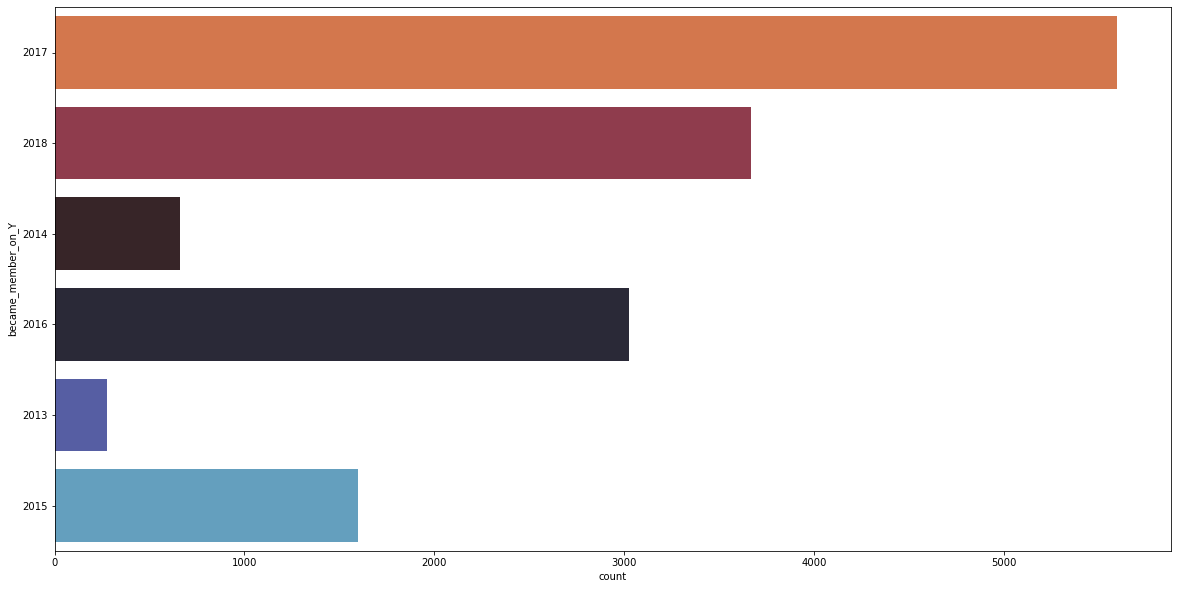

In [101]:
plt.figure(figsize=(20,10))
sns.countplot(data=profile, y='became_member_on_Y', palette='icefire_r');

In [102]:
profile['became_member_on_Y'].value_counts()

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Freq: A-DEC, Name: became_member_on_Y, dtype: int64

So it's clear for us that's in 2017 starbucks had got more new members than other years and to be more detailed:
- at the year 2017 starbucks had 5599 new customers 
- at the year 2018 starbucks had 3669 new customers 
- at the year 2016 starbucks had 3024 new customers 
- at the year 2015 starbucks had 1597 new customers 
- at the year 2014 starbucks had 662 new customers 
- at the year 2013 starbucks had 274 new customers 

## What is the average Income of the customers we have in the data? And What's the most duplicated amount between the customers?

In [103]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [104]:
income_bins = [0,10000,30000,50000,60000,80000,90000,150000]
income_labels = ['0-10,000', '11,000-30,000', '31,000-60,000', '61,000-90,000', '91,000-100,000','100,000-110,000','110k+']
profile['Income1'] = pd.cut(x=profile['income'], bins=income_bins, labels=income_labels, include_lowest = True)

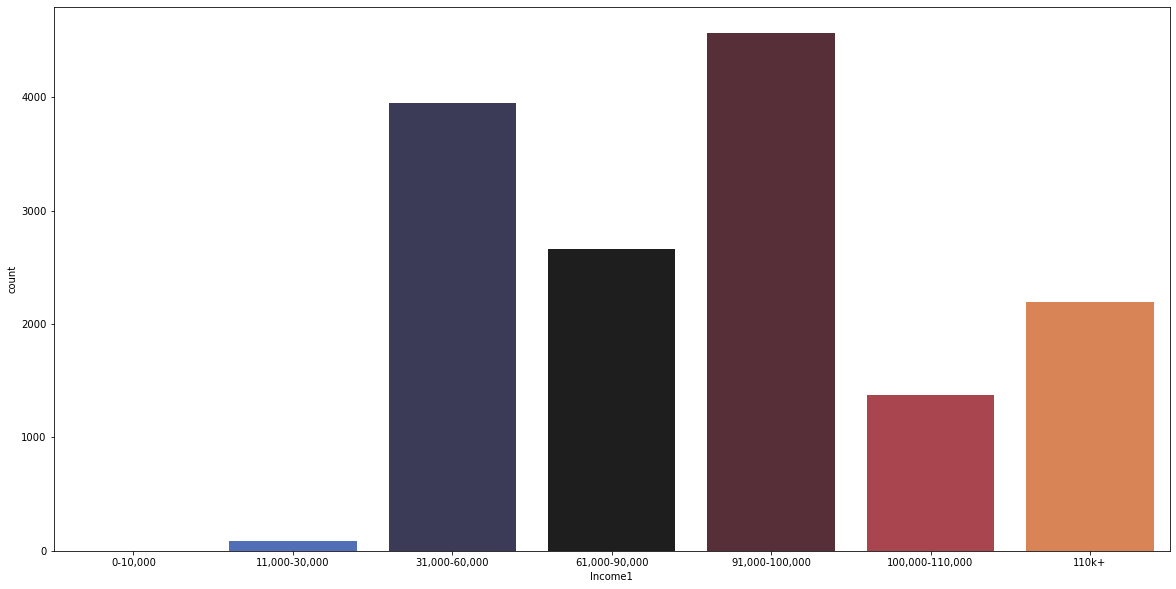

In [105]:
plt.figure(figsize=(20,10))
sns.countplot(data=profile, x='Income1', palette='icefire');

Looking at the preivous chart, we can see the distrubtion of the income of the customers and we noticed the following: 
- The average income is 65,404
- The Max income we have is 120,000 
- The Min income we have is 30,000 

## What is the distrubtion of gender?

In [106]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

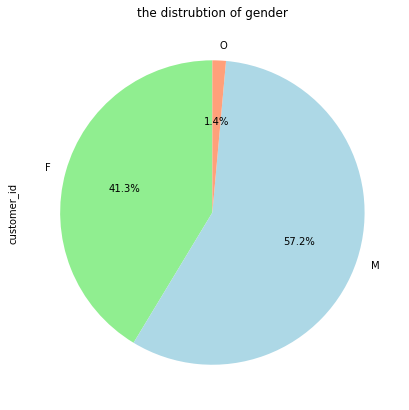

In [107]:
profile.groupby('gender').customer_id.count().plot(kind='pie' ,figsize=(7,7)  , startangle=90, autopct='%1.1f%%', 
                                                        title= "the distrubtion of gender" , 
                                                        colors = ['lightgreen', 'lightblue', 'lightsalmon']);


So we can conclude the following:
- 57.2% of the gender group are male and they are 8,484
- 41.3% of the gender group are female and they are 6,129
- 1.4% of the gender group are other or undefined and the are 212

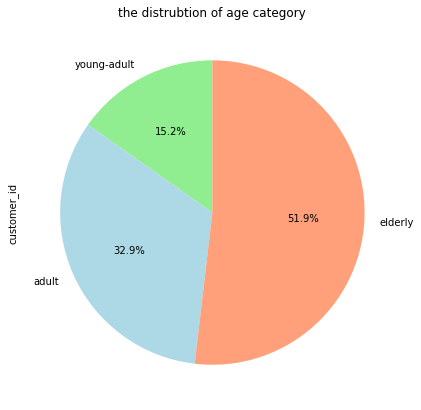

In [109]:
profile.groupby('age_category').customer_id.count().plot(kind='pie' ,figsize=(7,7)  , startangle=90, autopct='%1.1f%%', 
                                                        title= "the distrubtion of age category" , 
                                                        colors = ['lightgreen', 'lightblue', 'lightsalmon']);


In [110]:
profile['age_category'].value_counts()

elderly        7687
adult          4882
young-adult    2256
Name: age_category, dtype: int64

So we can conclude the following:
- 51.9% of the age category group are elderly and they are 7,687
- 32.9% of the age category group are adults and they are 4,882
- 15.2% of the age category group are young-adults and they are 2,256

## Now moving for the portfolio and transcript dataset to clean them and merging all of them together

#### Portfolio

In [113]:
def clean_portfolio(df):
    """
    performs the following:
        1- copy the dataframe to wrangle the data
        2- create binary columns from each channel in 'channels' column
        3- create binary columns from each offer type in 'offer_type' column then merge them with cleaned origianl dataframe 
        4- drop 'offer_type' and channels columns from cleaned origianl dataframe
        5- drop duplicated row if they exist
    
    args:
        df (Dataframe): the offers portfolio dataset dataframe
    
    return:
        df (Dataframe): the cleaned offers portfolio dataset dataframe
    """
    
    # copy the dataframe before wrangling the data 
    df = df.copy()
    
    #get the list of unique 'channels'
    channels = set()    
    for row in df.channels:
        channels = channels.union(set(row))
    
    # create binary columns from each channel in 'channels' column
    for channel in channels:
        df[channel] =  df['channels'].apply(lambda x: 1 if channel in x else 0)
    
    # create dataframe binary columns from each offer type in 'offer_type' column 
    df_offer_type = pd.get_dummies(df['offer_type'])
    
    # merge dataframe binary columns from each offer type in 'offer_type' column with cleaned origianl dataframe 
    df = pd.concat([df, df_offer_type], axis=1)
    
    # drop 'offer_type' and channels columns from cleaned origianl dataframe
    df.drop(['channels'], axis = 1, inplace=True)
    
    # drop duplicates
    print("number of duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("number of duplicates after the drop: ", df.duplicated().sum())
    
    
    # rename 'id' column to 'offer_id'
    df.rename(columns={'id':'offer_id'}, inplace=True)
    
    return df

In [114]:
portfolio = clean_portfolio(portfolio)

number of duplicates:  0


In [115]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,social,mobile,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


#### Transcript 

In [116]:
def extarct_value_column_values_to_transaction_amount_column(transcript):
    """
    extarct 'value' column values from to separate column:
        - if the event column value is 'transaction' then extarct 'amount' value to 'transaction_amount' column
              
    args:
       transcript (Series): row from transcript datafteme
    
    return:
       float as transaction_amount or Nan
    
    """
    if transcript['event'] == 'transaction':
        return transcript['value']['amount']
    else:
        return np.nan

In [117]:
def extarct_value_column_values_to_offer_id_column(transcript):
    """
    extarct 'value' column values from to separate columns:
        - if the event column value is not 'transaction' then extarct 'offer id' value to 'offer_id' column
            
    args:
       transcript (Series): row from transcript datafteme
    
    return:
        String as offer_id or None
    """
    if transcript['event'] != 'transaction':
        if 'offer id'in transcript['value'].keys() :
            return transcript['value']['offer id']
        else:
            return transcript['value']['offer_id']
    else:
        return None

In [119]:
def clean_transcript(df):
    """
    performs the following:
        1- copy the dataframe to wrangle the data
        2- create new 'offer_id' and 'transaction_amount' columns with null values
        3- extarct 'transaction_amount' column values from value column values 
        4- extarct 'offer_id' column values from value column values
        5- create binary columns from each transcript event type in 'event' column then merge them with cleaned origianl dataframe 
        6- drop 'value' and 'event' columns from cleaned origianl dataframe
        7- drop duplicated row if they exist
        8- rename 'person' column to 'uesr_id'
    
    args:
        df (Dataframe): the offers transcript dataset dataframe
    
    return:
        df (Dataframe): the cleaned offers transcript dataset dataframe
    """
    
    # copy the dataframe before wrangling the data 
    df = df.copy()
    
    # create new 'offer_id' and 'transaction_amount' columns with null values
    df['offer_id'] = None
    df['transaction_amount'] = np.nan
    
    # extarct 'transaction_amount' column values from 'value' column values 
    df['transaction_amount'] = df.apply(lambda row : extarct_value_column_values_to_transaction_amount_column(row),axis=1)
    
    # extarct 'offer_id' column values from 'value' column values 
    df['offer_id'] = df.apply(lambda row : extarct_value_column_values_to_offer_id_column(row),axis=1)
    
    
    # create dataframe binary columns from each transcript event in 'event' column 
    df_event = pd.get_dummies(df['event'])
    
    # merge dataframe binary columns from each transcript event in 'event' column with cleaned origianl dataframe 
    df = pd.concat([df, df_event], axis=1)
    
    # drop 'value' and 'event' columns from cleaned origianl dataframe
    df.drop(['value'], axis = 1, inplace=True)
    
    # drop duplicates
    print("number of duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("number of duplicates after the drop: ", df.duplicated().sum())
    
    # rename 'person' column to 'uesr_id'
    df.rename(columns={'person':'customer_id'}, inplace=True)
    
    return df

In [120]:
transcript = clean_transcript(transcript)

number of duplicates:  397
number of duplicates after the drop:  0


In [121]:
transcript

,customer_id,event,time,offer_id,transaction_amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53,0,0,0,1


In [123]:
df = transcript.merge(portfolio, on='offer_id',how='left')

In [124]:
df.head()

,customer_id,event,time,offer_id,transaction_amount,offer completed,offer received,offer viewed,transaction,reward,difficulty,duration,offer_type,web,email,social,mobile,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0


## Check what kind of offer type had the highest number of customers?

In [125]:
df['offer_type'].value_counts()

bogo             71449
discount         69669
informational    26066
Name: offer_type, dtype: int64

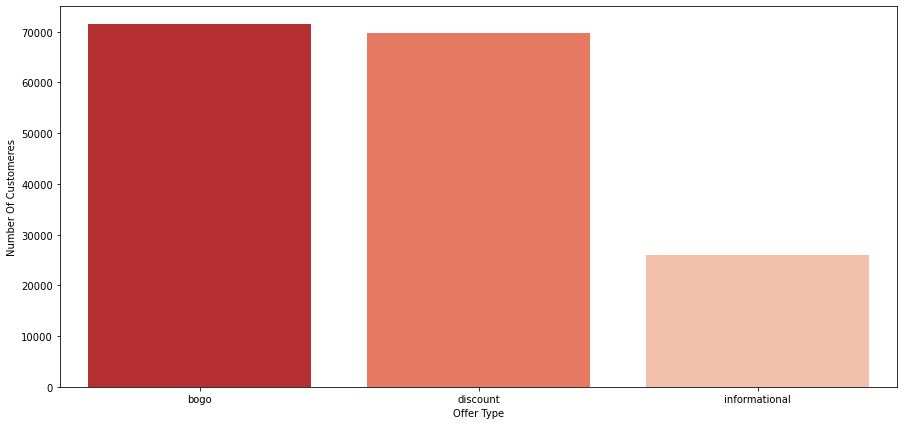

In [135]:
plt.figure(figsize=(15,7))
sns.countplot(data=df, x='offer_type', palette='Reds_r')
plt.xlabel('Offer Type')
plt.ylabel('Number Of Customeres');

looking at the preivous visulization:
- BOGO had the highest number of customers where there was 71,449 customers
- For the discount offer, it was close to the BOGO offer where it had 69,669 customers
- Where the Informational had the least with 26,066

## What is the amount that the customers usaually pay? and what is the average of the amounts?

In [140]:
df['transaction_amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: transaction_amount, dtype: float64

In [146]:
income_bins = [0,1,5,10,20,50,100,500,1000]
income_labels = ['1$','1$-5$','5$-10$','10$-20$','20$-50$','50$-100$','100$-500$','500$+']
df['transaction_amount1'] = pd.cut(x=df['transaction_amount'], bins=income_bins, labels=income_labels, include_lowest = True)

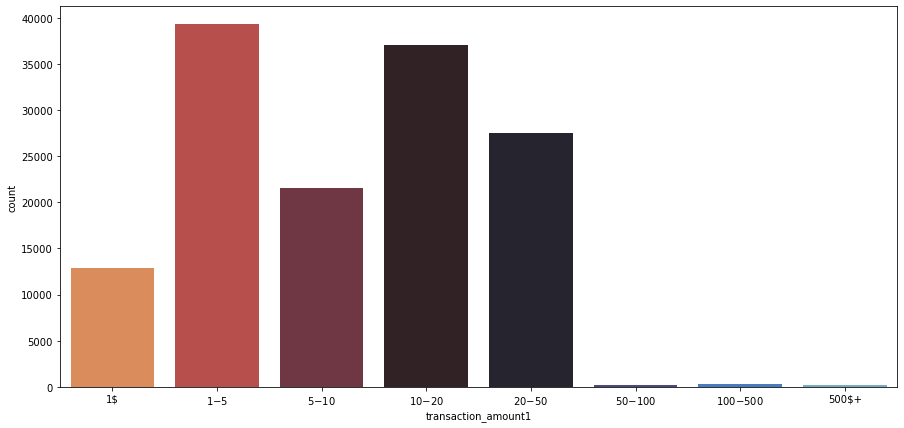

In [150]:
plt.figure(figsize=(15,7))
sns.countplot(data=df, x='transaction_amount1', palette='icefire_r');

from that chart we can know the following:
- The average amount of each transaction is 12.77 USD
- we can see that the max transaction was 1062 USD 
- and the min transaction was 0.05 USD 
- in the chart we can see the distrubtion of the amount transactions 

## Improvements

so after I finished analyzing the data, I can notice there is some view missing data that could be useful to us, for example if we have the data of what kind of order did the customer buy and what kind of coffee and study the reasons behind why the customers like these products and do more offers with these products to increase sales.

## Conclusion

the following is my conclusion through the analysis that I did:
- BOGO is the most offer type is liked by customers and closely to that comes the discounts offer
- We Saw that most of the customers we have are males, we can see the historical data and see what they ordered and do more offers for what they liked.
- the customers had good income number so we should do offers that will attract them to buy more